In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import plotting_fxns as plotfxns

This notebook is intended to make plotting of the PyGEM-EB output straightforward for fast diagnostics after a model run. Most functions just need the information for the model run in the cell below. 

Specify the plotting style to use and the figure name to save the plot.

In [3]:
# Define additional plotting variables
style.use('seaborn')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 
today = str(pd.Timestamp.today()).replace('-','_')[0:10]
figname = 'Figure'+today+'.png'

Run the following cells to plot the data. For information on any of the plotting functions, run 'help(name_of_function)'. Available functions are:
- plot_avgs
- plot_yrs
- plot_avg_layers
- plot_layers_monthly

In [11]:
# Load in the data and define the number of years in the model run
file = '/home/claire/research/Output/EB/run_2023_09_14_hourly_0.nc' # run_2023_09_20_hourly_0
ds = xr.open_dataset(file)
startdate = pd.to_datetime(ds.indexes['time'].to_numpy()[0])
enddate = pd.to_datetime(ds.indexes['time'].to_numpy()[-1])
ds['SWnet'] = ds['SWin'] + ds['SWout']
ds['LWnet'] = ds['LWin'] + ds['LWout']
ds['NetRad'] = ds['SWnet'] + ds['LWnet']
ds['albedo'] = -ds['SWout'] / ds['SWin']
ds['sum'] = ds['SWnet'] + ds['LWnet'] + ds['rain'] + ds['sensible'] + ds['latent']
nyr = enddate.year-startdate.year 

In [12]:
MB_vars = ['melt','runoff','accum','refreeze'] # ,'snowdepth'
EB_vars = ['surftemp','SWnet','LWnet','rain','sensible','latent','meltenergy']
temp_vars = ['airtemp','surftemp']

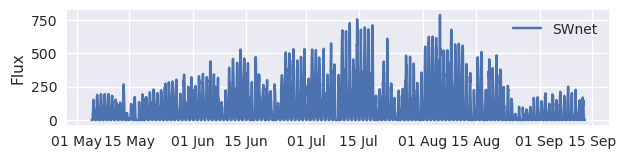

In [19]:
plotfxns.simple_plot(ds,[startdate,enddate],[['SWnet']],colors,res='h')

In [14]:
file = '/home/claire/research/Output/EB/run_2023_09_14_hourly_0.nc'
# 9-14 0 is with modeled LW, 2 is with input NR data
ds = xr.open_dataset(file)
ds['SWnet'] = ds['SWin'] + ds['SWout']
ds['LWnet'] = ds['LWin'] + ds['LWout']
ds['NetRad'] = ds['SWnet'] + ds['LWnet']
ds['albedo'] = -ds['SWout'] / ds['SWin']
ds['sum'] = ds['SWnet'] + ds['LWnet'] + ds['rain'] + ds['sensible'] + ds['latent']
ds1 = ds

In [15]:
file = '/home/claire/research/Output/EB/run_2023_09_14_hourly_2.nc'
ds = xr.open_dataset(file)
ds['SWnet'] = ds['SWin'] + ds['SWout']
ds['LWnet'] = ds['LWin'] + ds['LWout']
ds['NetRad'] = ds['SWnet'] + ds['LWnet']
ds['albedo'] = -ds['SWout'] / ds['SWin']
ds['sum'] = ds['SWnet'] + ds['LWnet'] + ds['rain'] + ds['sensible'] + ds['latent']
ds2 = ds

In [2]:
fp = '/home/claire/research/climate_data/AWS/Raw/on-Glacier/Zongo_surglacier_yrs.xlsx'
yrs = ['0405','0506','0607','0708','0809','0910','1011','1112','1213','1314','1415','1516','1617','1718','1819']
for yr in yrs:
    df = pd.read_excel(fp.replace('yrs',yr))
    if yr in ['0405']:
        df_all = df
    else:
        df_all = pd.concat([df_all,df])
print(df_all)

                                                SAMA Unnamed: 1  \
0                            Centrale Campbell CR10X        NaN   
1                    Programme : SAMA1_ORE_ZONGO.CR1        NaN   
2                                 Table : 30 minutes        NaN   
3                                   Glacier du Zongo        NaN   
4      Station météorologique "sur glacier" à 5050 m        NaN   
...                                              ...        ...   
35044                            2019-08-31 22:45:00          0   
35045                            2019-08-31 23:00:00          0   
35046                            2019-08-31 23:15:00          0   
35047                            2019-08-31 23:30:00          0   
35048                            2019-08-31 23:45:00          0   

               Année 2004-2005 Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6  \
0      GLACIOCLIM (IRD - UMSA)        NaN        NaN        NaN        NaN   
1                          NaN        N

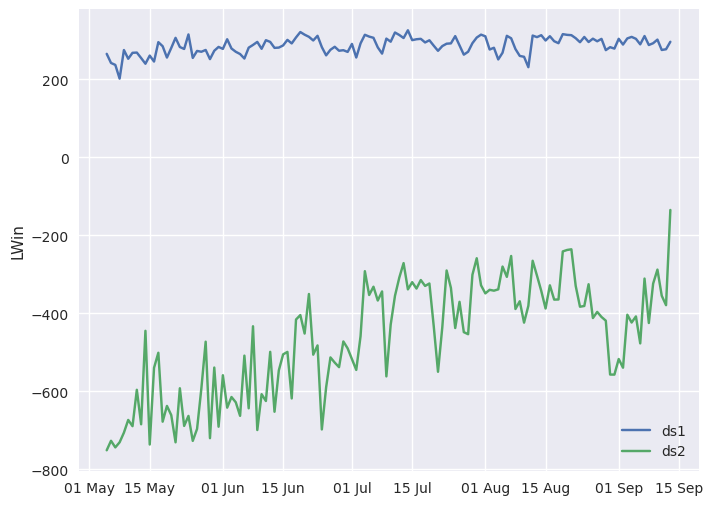

In [16]:
plotfxns.compare_runs(ds1,ds2,[startdate,enddate],'LWin',colors,'d')

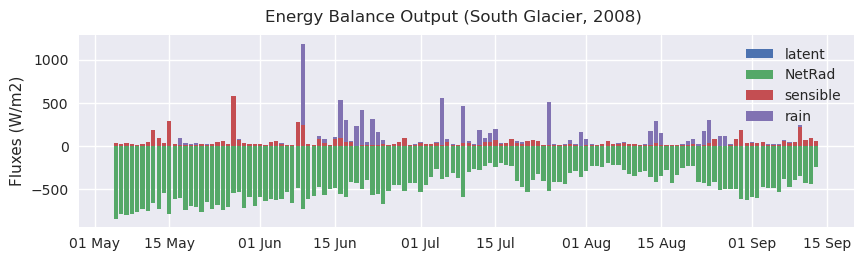

In [13]:
# 'layertemp','layerdensity','layerwater','layerheight'
plotfxns.stacked_eb_barplot(ds,[startdate,enddate],colors,'d','Energy Balance Output (South Glacier, 2008)')
# plotfxns.simple_plot(ds,[startdate,enddate],['snowdepth','LWin','LWout'],colors,'h')

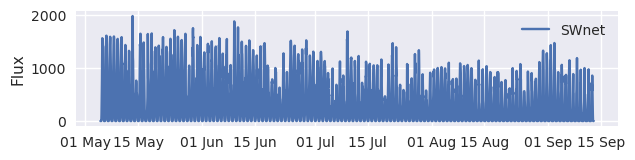

In [14]:
plotfxns.simple_plot(ds,[startdate,enddate],[['SWnet']],colors,res='h')

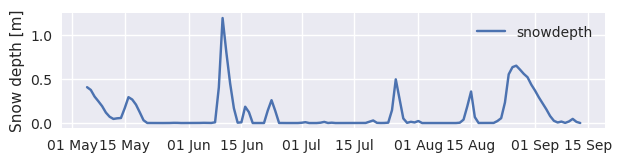

In [28]:
plotfxns.simple_plot(ds1,[startdate,enddate],[['snowdepth']],colors,res='d')

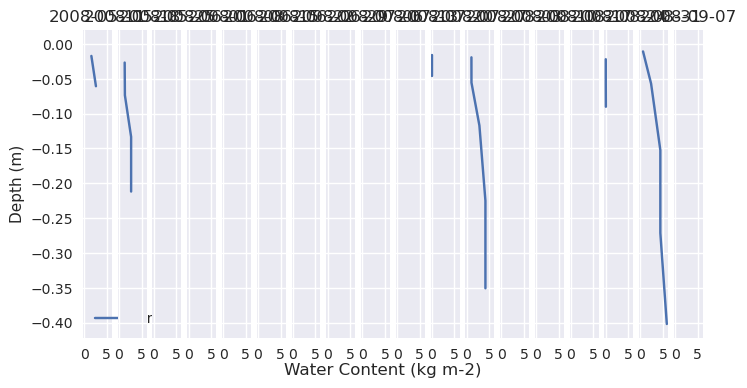

In [29]:
plotfxns.plot_layers(ds1,'layerwater',pd.date_range(startdate,enddate,freq='1W'))

ValueError: cannot reshape array of size 3097 into shape (24,130)

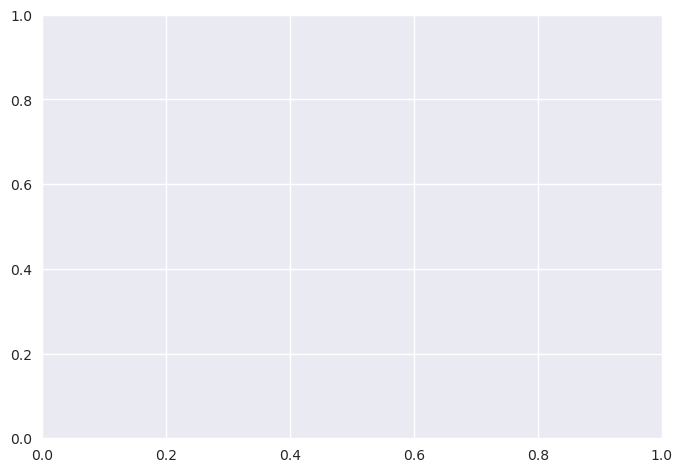

In [26]:
vars = ['tcc']
df = pd.read_csv('/home/claire/research/climate_data/AWS/Preprocessed/south/south2280_hourly_2008.csv',index_col=0)
# df['temp'] = df['T']
plotfxns.plot_AWS(df,vars,[startdate+pd.Timedelta(days=2),enddate])

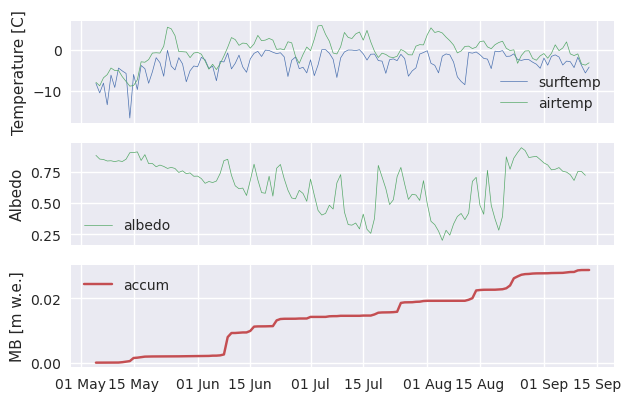

In [52]:
plotfxns.simple_plot(ds,[startdate,enddate],[['surftemp','airtemp'],['albedo'],['accum']],colors,res='d')

In [1]:
import pandas as pd
df = pd.read_csv('~/research/climate_data/AWS/Preprocessed/south/south2280_hourly_2008.csv',index_col=0)
start = df.index[0]
end = df.index[len(df.index)-1]

df2 = pd.read_csv('~/research/climate_data/AWS/Raw/SouthGlacier_AWS_FiveMinData.csv')
df2 = df2.set_index(pd.DatetimeIndex(df2['TIMESTAMP']))
df2 = df2.loc[start:end]
df2 = df2['CNR_Wm2_Avg'].resample('h').mean()
df['NR'] = df2
print(df)

/tmp/ipykernel_332/764770260.py:6: DtypeWarning: Columns (11,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('~/research/climate_data/AWS/Raw/SouthGlacier_AWS_FiveMinData.csv')


                         wind     winddir       temp         rh     SWin  \
Unnamed: 0                                                                 
2008-05-01 00:00:00  1.815917  338.000000 -10.540833  53.237500      NaN   
2008-05-01 01:00:00  1.284583  287.365833 -10.531667  49.205000      NaN   
2008-05-01 02:00:00  1.418500  285.822667 -10.480000  48.512500      NaN   
2008-05-01 03:00:00  1.162500  319.044167 -10.470833  51.090833      NaN   
2008-05-01 04:00:00  1.290500  279.094167 -10.570000  55.245833      NaN   
...                       ...         ...        ...        ...      ...   
2008-09-13 20:00:00  2.869750  159.900000  -2.475750  76.839167  29919.6   
2008-09-13 21:00:00  3.747667  151.800000  -2.323833  76.252500     19.8   
2008-09-13 22:00:00  3.213750  151.866667  -2.411667  77.056667      0.0   
2008-09-13 23:00:00  4.122000  141.701667  -2.066917  74.851667      0.0   
2008-09-14 00:00:00  8.240000  158.200000  -2.110000  76.000000      0.0   

           

In [52]:
import numpy as np
df3 = pd.read_csv('~/research/climate_data/AWS/Artesonraju/artesonraju_hourly.csv')
df3['z'] = 4797
df3.to_csv('~/research/climate_data/AWS/Preprocessed/artesonraju/artesonraju4797_hourly.csv')

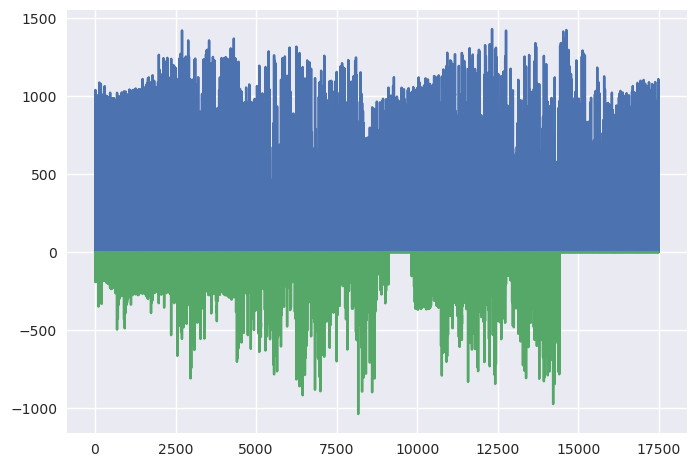

In [53]:
plt.plot(df3.index,df3['SWin'])
plt.plot(df3.index,df3['SWout']*-1)

In [58]:
print(df3[9990:10000])

               Unnamed: 0      SWin    SWout    LWin   LWout        T      rh  \
9990  2017-07-22 06:00:00     0.000    0.000  179.50  284.00  271.875  17.622   
9991  2017-07-22 07:00:00     0.000    0.000  177.85  282.65  271.721  15.513   
9992  2017-07-22 08:00:00   354.263  100.565  182.70  287.30  272.234  17.226   
9993  2017-07-22 09:00:00   627.040  235.050  191.45  300.30  273.246  20.765   
9994  2017-07-22 10:00:00   835.446  293.000  200.15  309.50  273.654  27.600   
9995  2017-07-22 11:00:00   982.887  320.700  205.45  313.00  274.045  31.297   
9996  2017-07-22 12:00:00  1049.679  340.650  209.25  314.75  274.273  33.895   
9997  2017-07-22 13:00:00  1036.032  348.300  213.45  316.20  274.666  34.663   
9998  2017-07-22 14:00:00   937.209  333.450  216.30  316.90  274.958  36.781   
9999  2017-07-22 15:00:00   768.156  290.400  217.75  316.65  275.095  38.189   

           sp   wind   tp    tcc  dtemp     z  
9990  727.293  9.225  0.0  0.000    NaN  4797  
9991  729.64

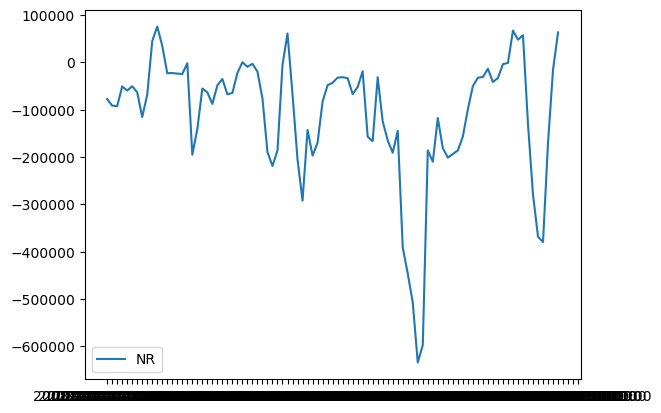

In [3]:
import matplotlib.pyplot as plt
df['NR'] = df2*3600
plt.plot(df.index,df['NR'],label='NR')
# plt.plot(df.index,df['SWin'],label='SW')
plt.legend()
plt.show()

In [58]:
df.to_csv('~/research/climate_data/AWS/Preprocessed/south/south2280_hourly_2008_wNR.csv')

In [20]:
months_to_plot = np.int64(np.linspace(0,11,5))
# plotfxns.plot_layers_monthly(file,'layertemp',months_to_plot,colors)
# plotfxns.plot_avgs(file,nyr,title='South Glacier')

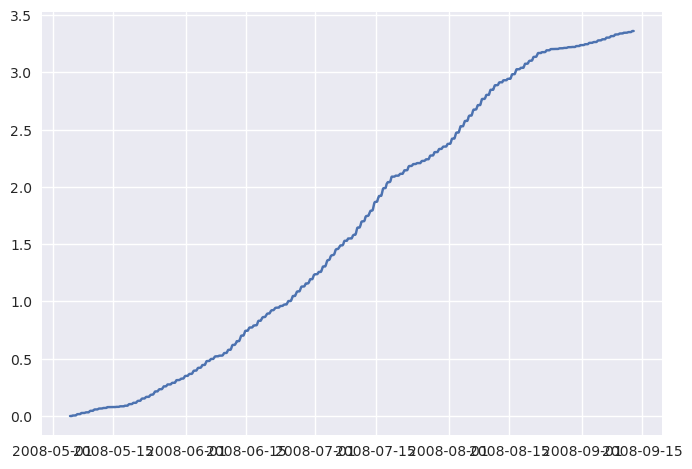

In [53]:
plt.plot(ds.coords['time'],np.cumsum(ds.melt))
plt.show()

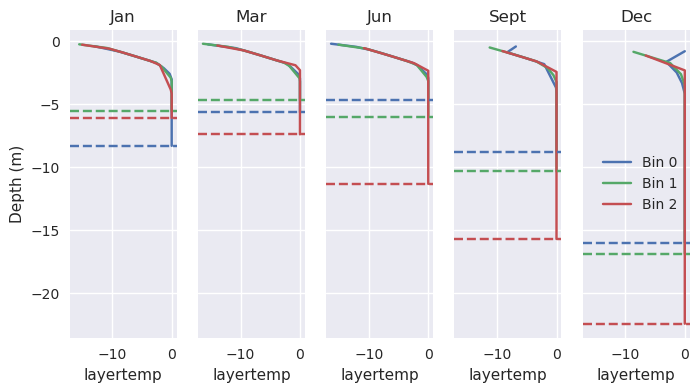

In [ ]:
plotfxns.plot_layers_monthly(file,'layertemp',months_to_plot,colors)

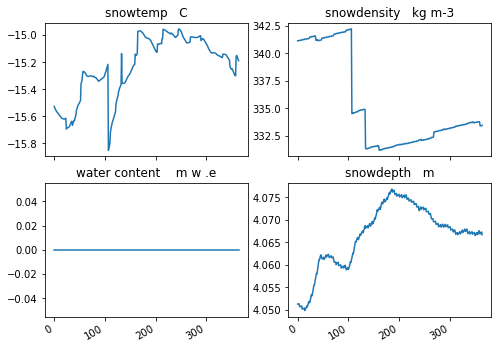

In [ ]:
plot_avg_layers(file,bin,nyr)

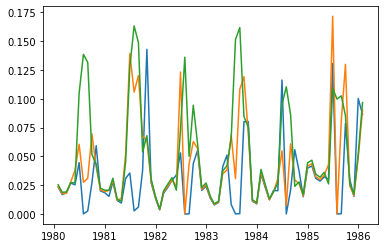

In [ ]:
ds = xr.open_dataset(file)
accum = ds['accum'].to_pandas()
accum = accum.resample('M').mean()*1000
plt.plot(accum.index,accum)
plt.show()

In [ ]:
import xarray as xr
ds = xr.open_dataset('/home/claire/research/climate_data/ERA5/ERA5_hourly/ERA5_precip_hourly.nc')
print(np.mean(ds['tp'].values),np.max(ds['tp'].values))
print(np.sum(ds['tp'].values[:8790]))

9.609282174515584e-05 0.004886787384748459


In [ ]:
# def plot_diurnal(file,bin):
ds = xr.open_dataset(file)
fig,axes = plt.subplots(2,2,sharey=True,sharex=True,figsize=(8,4)) #,sharex=True,sharey='row'
df = ds['snowdepth'].to_pandas()